<a href="https://colab.research.google.com/github/caffeicsatyam/Small-Machine-Learning-Projects/blob/main/Fine_tunning_Distilbart_for_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [3]:
import os
import pandas
from datasets import load_dataset

In [4]:
emotion = load_dataset('emotion')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
emotion.set_format(type='pandas')

In [6]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
df = emotion['train'][:]

In [8]:
classes = emotion['train'].features['label'].names

In [9]:
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [10]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Data Analysis

In [12]:
import matplotlib.pyplot as plt

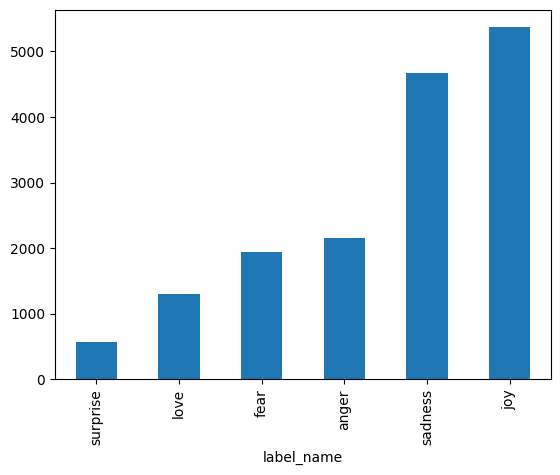

In [13]:
label_counts = df['label_name'].value_counts(ascending=True )
label_counts.plot(kind='bar')   # 👈 call the function
plt.show()
plt.show()

In [14]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [15]:
df['words'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'words'}, xlabel='label_name'>

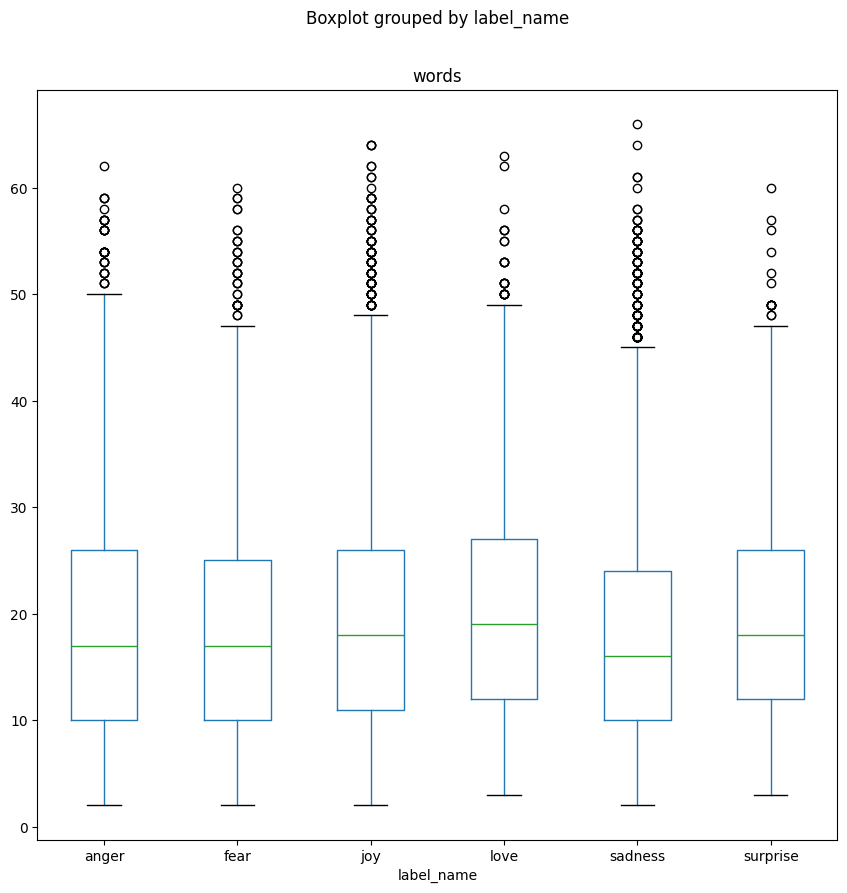

In [16]:
df.boxplot('words', by='label_name', grid=False, figsize=(10,10))

# The DistilBART model generally has a vocabulary size of
# 50,264 tokens and a maximum sequence length (context size) of 1024 tokens.
#  This is larger than the more common 512 token limit found in
# models like DistilBERT

In [17]:
# Text to Tokens

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
text = 'I love machin learning!, Tokenizer is awsome'
encoded_text = tokenizer(text)

In [19]:
encoded_text

{'input_ids': [101, 1045, 2293, 24532, 2378, 4083, 999, 1010, 19204, 17629, 2003, 22091, 14045, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [21]:
tokens

['[CLS]',
 'i',
 'love',
 'mach',
 '##in',
 'learning',
 '!',
 ',',
 'token',
 '##izer',
 'is',
 'aw',
 '##some',
 '[SEP]']

In [22]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

In [23]:
# Tokenization of Emotion Data

In [24]:
emotion.reset_format()

In [25]:
def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [26]:
print(tokenize(emotion["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1,

In [27]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [28]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Model Building

In [29]:
text

'I love machin learning!, Tokenizer is awsome'

In [30]:
input  = tokenizer(text, return_tensors='pt')
input

{'input_ids': tensor([[  101,  1045,  2293, 24532,  2378,  4083,   999,  1010, 19204, 17629,
          2003, 22091, 14045,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [31]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [33]:
# input.pop("token_type_ids", None)

with torch.no_grad():
    outputs = model(**input)

last_hidden_states = outputs.last_hidden_state

In [34]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-5.1180e-02,  1.6473e-01,  1.3897e-01,  ..., -2.3657e-01,
           2.9442e-01,  4.7644e-01],
         [ 4.8570e-01,  4.9282e-01,  3.2368e-01,  ..., -3.6308e-01,
           6.4117e-01,  5.7688e-01],
         [ 8.4082e-01,  9.8416e-01,  9.0201e-01,  ...,  3.6491e-03,
           3.6362e-01, -8.3562e-03],
         ...,
         [-5.9153e-01,  5.5189e-01,  9.2495e-01,  ..., -6.7079e-01,
          -1.7806e-01, -1.6645e-01],
         [-5.1615e-01,  2.7830e-01,  4.2577e-01,  ...,  3.7701e-04,
          -5.9644e-02, -1.5838e-01],
         [ 6.5391e-01,  5.0663e-01,  5.5090e-02,  ..., -1.5097e-01,
          -8.1460e-01,  7.5260e-02]]]), pooler_output=tensor([[-0.6466, -0.2475, -0.5673,  0.5061,  0.4306,  0.0343,  0.6772,  0.1120,
         -0.3126, -0.9998,  0.1114,  0.5430,  0.9520,  0.2841,  0.8451, -0.4684,
          0.1278, -0.4440,  0.3055, -0.0562,  0.5217,  0.9992,  0.3111,  0.2153,
          0.2701,  0.6773, -0.588

In [35]:
last_hidden_states

tensor([[[-5.1180e-02,  1.6473e-01,  1.3897e-01,  ..., -2.3657e-01,
           2.9442e-01,  4.7644e-01],
         [ 4.8570e-01,  4.9282e-01,  3.2368e-01,  ..., -3.6308e-01,
           6.4117e-01,  5.7688e-01],
         [ 8.4082e-01,  9.8416e-01,  9.0201e-01,  ...,  3.6491e-03,
           3.6362e-01, -8.3562e-03],
         ...,
         [-5.9153e-01,  5.5189e-01,  9.2495e-01,  ..., -6.7079e-01,
          -1.7806e-01, -1.6645e-01],
         [-5.1615e-01,  2.7830e-01,  4.2577e-01,  ...,  3.7701e-04,
          -5.9644e-02, -1.5838e-01],
         [ 6.5391e-01,  5.0663e-01,  5.5090e-02,  ..., -1.5097e-01,
          -8.1460e-01,  7.5260e-02]]])

In [36]:
# hidden state - total token - total numbers
last_hidden_states.shape

torch.Size([1, 14, 768])

# Fine TUnning

In [37]:
from transformers import AutoModelForSequenceClassification
num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
device

device(type='cuda')

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from transformers import TrainingArguments

batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False
)


In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args = training_args,
    compute_metrics=compute_metrics,
    train_dataset= emotions_encoded["train"],
    eval_dataset= emotions_encoded["validation"],
    tokenizer=tokenizer
)


/tmp/ipython-input-1793279252.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.283620,0.911000,0.911820
2,0.497000,0.196146,0.925500,0.925416


TrainOutput(global_step=500, training_loss=0.49699542236328126, metrics={'train_runtime': 534.5892, 'train_samples_per_second': 59.859, 'train_steps_per_second': 0.935, 'total_flos': 1430717745024000.0, 'train_loss': 0.49699542236328126, 'epoch': 2.0})

In [44]:
preds_outputs = trainer.predict(emotions_encoded["test"])
preds_outputs.metrics

{'test_loss': 0.18956051766872406,
 'test_accuracy': 0.9265,
 'test_f1': 0.926306082876287,
 'test_runtime': 6.931,
 'test_samples_per_second': 288.559,
 'test_steps_per_second': 4.617}

In [46]:
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded["test"][:]["label"]

In [47]:
from sklearn.metrics import classification_report
print(classes)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [48]:
print(classification_report(y_true, y_preds, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.94      0.95       695
        love       0.81      0.87      0.84       159
       anger       0.92      0.94      0.93       275
        fear       0.89      0.91      0.90       224
    surprise       0.80      0.67      0.73        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [50]:
label_counts

,count
label_name,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


In [51]:
text = "What a time to be alive"

In [63]:
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits  # Correctly access the logits from the model output
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(1, 'joy')